# Transfer Learning

In [1]:
!pip install tensorflow_io

     |████████████████████████████████| 23.4 MB 1.7 MB/s 


In [2]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import shuffle

## Load data

We will use the test set of the "speech commands" dataset published by Peter Warden in conjunction with the paper [1804.03209](https://arxiv.org/abs/1804.03209).

The training set is located [here](http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz).

In [3]:
_ = tf.keras.utils.get_file('speech_commands.zip',
                        'http://download.tensorflow.org/data/speech_commands_test_set_v0.02.tar.gz',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)

112574464/112563277 [==============================] - 1s 0us/step


In [4]:
data = []
labels_dict = {}
i = -1
for folder, labels, samples in os.walk('./datasets/'):
    if folder[11:]:
        i += 1
        labels_dict[i] = folder[11:]
    for sample in samples:
        if sample[-3:] == 'wav':
            data.append([folder+'/'+sample, i, folder[11:]])
labels_reverse_dict = {y:x for x,y in labels_dict.items()}

In [5]:
data = pd.DataFrame(data, columns=['filename', 'label', 'category'])
data.head()

,filename,label,category
0,./datasets/left/37dca74f_nohash_1.wav,0,left
1,./datasets/left/44260689_nohash_0.wav,0,left
2,./datasets/left/fce96bac_nohash_2.wav,0,left
3,./datasets/left/f428ca69_nohash_2.wav,0,left
4,./datasets/left/6021f08b_nohash_0.wav,0,left


In [6]:
labels_reverse_dict.keys()

dict_keys(['left', 'on', 'go', '_unknown_', 'up', 'off', 'yes', 'stop', 'down', 'right', 'no', '_silence_'])

In [7]:
data['category'].unique()

array(['left', 'on', 'go', '_unknown_', 'up', 'off', 'yes', 'stop',
       'down', 'right', 'no', '_silence_'], dtype=object)

In [8]:
data_shuffled = data.sample(frac = 1)

In [9]:
nums = 4400
train_data_paths = np.array(data_shuffled['filename'][:nums])
train_labels = np.array(data_shuffled['label'][:nums])
test_data_paths = np.array(data_shuffled['filename'][nums:])
test_labels = np.array(data_shuffled['label'][nums:])

In [10]:
def load_audio(filepath):
    audio = tfio.audio.AudioIOTensor(filepath)
    audio_rate = int(audio.rate)
    assert audio_rate == 16000
    return tf.cast(tf.squeeze(audio.to_tensor(), axis=[-1]), tf.float32) / 32767.0

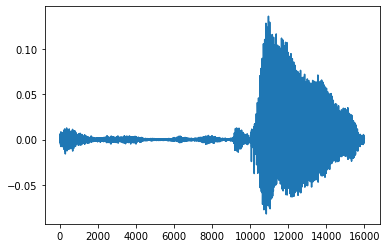

In [11]:
testing_file = train_data_paths[-1]
testing_sample = load_audio(testing_file)


_ = plt.plot(testing_sample)

# Play the audio file.
display.Audio(testing_sample,rate=16000)

## Train a model from scratch

In [12]:
nums = 4400
train_data_paths = np.array(data_shuffled['filename'][:nums])
train_labels = np.array(data_shuffled['label'][:nums])
test_data_paths = np.array(data_shuffled['filename'][nums:])
test_labels = np.array(data_shuffled['label'][nums:])

In [13]:
train_data = []
for path in train_data_paths:
    train_data.append(load_audio(path))

test_data = []
for path in test_data_paths:
    test_data.append(load_audio(path))

In [14]:
train_data[0]

<tf.Tensor: shape=(16000,), dtype=float32, numpy=
array([-0.00167852, -0.00326548, -0.00418104, ...,  0.00305185,
        0.00210578,  0.00253304], dtype=float32)>

In [15]:
def get_spectrogram(waveform):
    # Zero-padding for an audio waveform with less than 16,000 samples.
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
        [16000] - tf.shape(waveform),
        dtype=tf.float32)
    # Cast the waveform tensors' dtype to float32.
    waveform = tf.cast(waveform, dtype=tf.float32)
    # Concatenate the waveform with `zero_padding`, which ensures all audio
    # clips are of the same length.
    equal_length = tf.concat([waveform, zero_padding], 0)
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
        equal_length, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [16]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

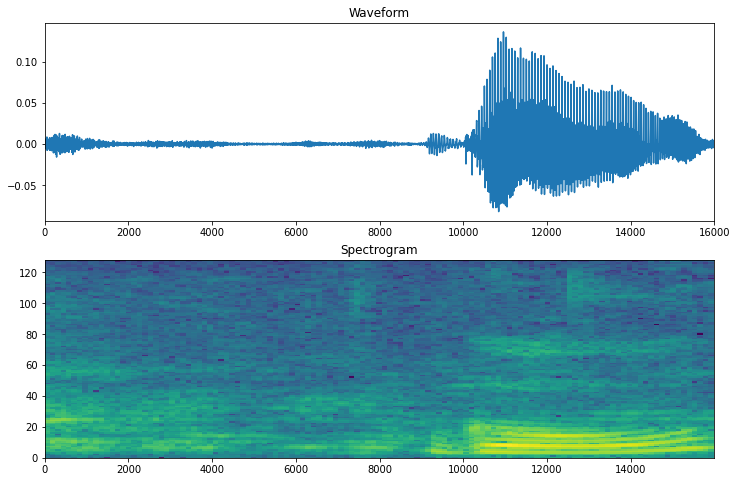

In [17]:
waveform = testing_sample
spectrogram = get_spectrogram(waveform)
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()
display.Audio(testing_sample,rate=16000)

In [19]:
train_data_s = []
for i in range(len(train_data)):
    train_data_s.append(get_spectrogram(train_data[i]))

train_data_s = np.array(train_data_s)
train_data_s.shape

KeyboardInterrupt: ignored

In [20]:
spectrogram.shape

TensorShape([124, 129, 1])

In [ ]:
train_labels.shape

(4400,)

In [ ]:
input_shape = spectrogram.shape
num_labels = len(labels_dict)
model = keras.Sequential([layers.Input(shape=input_shape),
                          layers.Resizing(32, 32),
                          layers.Conv2D(32, 3, activation='relu'),
                          layers.Conv2D(64, 3, activation='relu'),
                          layers.MaxPooling2D(),
                          layers.Dropout(0.25),
                          layers.Flatten(),
                          layers.Dense(128, activation='relu'),
                          layers.Dropout(0.5),
                          layers.Dense(num_labels, activation='softmax'),
                          ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                        

In [ ]:
#tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam", metrics=['accuracy'])

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=3, restore_best_weights=True)

model.fit(train_data_s, train_labels, epochs=60, batch_size=256,
          validation_split=0.2, shuffle=True, callbacks = callback)

Epoch 1/60
14/14 [==============================] - 9s 40ms/step - loss: 2.2751 - accuracy: 0.2310 - val_loss: 2.0078 - val_accuracy: 0.3818
Epoch 2/60
14/14 [==============================] - 0s 19ms/step - loss: 1.9754 - accuracy: 0.3648 - val_loss: 1.8016 - val_accuracy: 0.4557
Epoch 3/60
14/14 [==============================] - 0s 19ms/step - loss: 1.7809 - accuracy: 0.4253 - val_loss: 1.6423 - val_accuracy: 0.5023
Epoch 4/60
14/14 [==============================] - 0s 18ms/step - loss: 1.6033 - accuracy: 0.4699 - val_loss: 1.5073 - val_accuracy: 0.5670
Epoch 5/60
14/14 [==============================] - 0s 18ms/step - loss: 1.4688 - accuracy: 0.5182 - val_loss: 1.4790 - val_accuracy: 0.5500
Epoch 6/60
14/14 [==============================] - 0s 19ms/step - loss: 1.3570 - accuracy: 0.5599 - val_loss: 1.3306 - val_accuracy: 0.5852
Epoch 7/60
14/14 [==============================] - 0s 18ms/step - loss: 1.2434 - accuracy: 0.5878 - val_loss: 1.2825 - val_accuracy: 0.6341
Epoch 8/60
14

In [ ]:
test_data_s = []
for i in range(len(test_data)):
    test_data_s.append(get_spectrogram(test_data[i]))

test_data_s = np.array(test_data_s)
test_data_s.shape

(490, 124, 129, 1)

In [ ]:
model.evaluate(test_data_s, test_labels)

16/16 [==============================] - 0s 4ms/step - loss: 0.8771 - accuracy: 0.7673


[0.8771415948867798, 0.7673469185829163]

A model from scratch on ~4000 samples can achieve 70-75% accuracy which is not bad. Now let's see what we can do with a pretrained model.

## Load pretrained model

We will use the YAMNet audio recognition model. YAMNet has not been trained as a speech recognition model, rather it was trained to classify sounds into classes such as 'shatter', 'laughter' and 'child speech'.

As a model that has also listened to human speech during training, YAMNet has learned to extract features that should be quite suitable for speech recognition.

In [ ]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

### Test the model

The model has 3 outputs the one of which is a classification with the following classes:

In [ ]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

class_names[:20]

['Speech',
 'Child speech, kid speaking',
 'Conversation',
 'Narration, monologue',
 'Babbling',
 'Speech synthesizer',
 'Shout',
 'Bellow',
 'Whoop',
 'Yell',
 'Children shouting',
 'Screaming',
 'Whispering',
 'Laughter',
 'Baby laughter',
 'Giggle',
 'Snicker',
 'Belly laugh',
 'Chuckle, chortle',
 'Crying, sobbing']

We can test this on our recorings of commands which should obviously be classified as speech!

## Transfer learning (indirect approach)

YAMNet is a pretty heavy model. We will look at it in detail later but since the model outputs "extracted features" for us to use, we can directly use those features and train a new model to classify our new data.

In [ ]:
#  这个模型有三个参数 output
#1. classification
#2. encoding?
#3. spectragram
在这里我们用  第二和第三个output  of  YAMNet
& 不需要convolution layers

In [ ]:
train_data_te = []
train_data_ts = []
for i in range(len(train_data)):
    x = yamnet_model(train_data[i])[1:]
    train_data_te.append(x[0])
    train_data_ts.append(x[1])

In [ ]:
train_data_te = tf.convert_to_tensor(train_data_te)
train_data_ts = tf.convert_to_tensor(train_data_ts)

[train_data_te.shape, train_data_ts.shape]

[TensorShape([4400, 2, 1024]), TensorShape([4400, 144, 64])]

### Using encodings

The model extracts "frames" of 0.96s duration every 0.48s. For our 1s long data this is simply a shift in the waveform which nonetheless can be treated as a new sample.

In [ ]:
train_data_te = tf.reshape(train_data_te, (-1, 1024))
train_labels_te = np.repeat(train_labels,2)

In [ ]:
num_classes = len(labels_dict)

model_te = keras.Sequential([layers.Input(shape=(1024)),
                             layers.Dense(256, activation='relu'),
                             layers.Dense(num_classes, activation='softmax')
                             ])

model_te.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dense_3 (Dense)             (None, 12)                3084      
                                                                 
Total params: 265,484
Trainable params: 265,484
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_te.compile(loss="sparse_categorical_crossentropy",
                 optimizer="adam", metrics=['accuracy'])

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=3, restore_best_weights=True)

model_te.fit(train_data_te, train_labels_te, epochs=60, batch_size=256,
             validation_split=0.2, shuffle=True, callbacks = callback)

Epoch 1/60
28/28 [==============================] - 0s 8ms/step - loss: 2.2432 - accuracy: 0.2315 - val_loss: 2.1416 - val_accuracy: 0.2716
Epoch 2/60
28/28 [==============================] - 0s 4ms/step - loss: 2.0075 - accuracy: 0.3173 - val_loss: 2.0353 - val_accuracy: 0.2920
Epoch 3/60
28/28 [==============================] - 0s 4ms/step - loss: 1.9035 - accuracy: 0.3526 - val_loss: 1.9992 - val_accuracy: 0.3000
Epoch 4/60
28/28 [==============================] - 0s 4ms/step - loss: 1.8449 - accuracy: 0.3777 - val_loss: 1.9607 - val_accuracy: 0.3153
Epoch 5/60
28/28 [==============================] - 0s 4ms/step - loss: 1.7903 - accuracy: 0.4041 - val_loss: 1.9209 - val_accuracy: 0.3381
Epoch 6/60
28/28 [==============================] - 0s 4ms/step - loss: 1.7481 - accuracy: 0.4200 - val_loss: 1.9094 - val_accuracy: 0.3386
Epoch 7/60
28/28 [==============================] - 0s 4ms/step - loss: 1.7024 - accuracy: 0.4325 - val_loss: 1.8893 - val_accuracy: 0.3398
Epoch 8/60
28/28 [==

In [ ]:
test_data_te=[]
test_data_ts=[]
for i in range(len(test_data)):
    x = yamnet_model(test_data[i])[1:]
    test_data_te.append( x[0] )
    test_data_ts.append( x[1] )

test_data_te = tf.reshape( test_data_te,(-1, 1024) )
test_labels_te = np.repeat(test_labels,2)

In [ ]:
model_te.evaluate(test_data_te, test_labels_te)

31/31 [==============================] - 0s 3ms/step - loss: 1.8152 - accuracy: 0.3673


[1.8152011632919312, 0.36734694242477417]

Clearly you can do a lot better by training a model from scratch! That's generally true if you have enough data and ~5000 samples for 12 classes is enough to train a model reasonably well. 

### Using spectrograms

In [ ]:
train_data_ts = tf.reshape(train_data_ts, (4400, 144, 64, 1))

In [ ]:
num_labels = len(labels_dict)
model_ts = keras.Sequential([layers.Input(shape=(144, 64, 1)),
                             layers.Resizing(32, 32),
                             layers.Conv2D(32, 3, activation='relu'),
                             layers.Conv2D(32, 3, activation='relu'),
                             layers.MaxPooling2D(),
                             layers.Dropout(0.25),
                             layers.Flatten(),
                             layers.Dense(128, activation='relu'),
                             layers.Dropout(0.5),
                             layers.Dense(num_labels, activation='softmax'),
                             ])

model_ts.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                      

In [ ]:
model_ts.compile(loss="sparse_categorical_crossentropy",
                 optimizer="adam", metrics=['accuracy'])

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=3, restore_best_weights=True)

model_ts.fit(train_data_ts, train_labels, epochs=60, batch_size=256,
             validation_split=0.2, callbacks = callback)

Epoch 1/60
14/14 [==============================] - 1s 28ms/step - loss: 2.6367 - accuracy: 0.1344 - val_loss: 2.3823 - val_accuracy: 0.1807
Epoch 2/60
14/14 [==============================] - 0s 13ms/step - loss: 2.3115 - accuracy: 0.1918 - val_loss: 2.2209 - val_accuracy: 0.2841
Epoch 3/60
14/14 [==============================] - 0s 13ms/step - loss: 2.1559 - accuracy: 0.2591 - val_loss: 1.9884 - val_accuracy: 0.3886
Epoch 4/60
14/14 [==============================] - 0s 13ms/step - loss: 1.9748 - accuracy: 0.3236 - val_loss: 1.7460 - val_accuracy: 0.4750
Epoch 5/60
14/14 [==============================] - 0s 13ms/step - loss: 1.7724 - accuracy: 0.4017 - val_loss: 1.5744 - val_accuracy: 0.5159
Epoch 6/60
14/14 [==============================] - 0s 13ms/step - loss: 1.6073 - accuracy: 0.4489 - val_loss: 1.4074 - val_accuracy: 0.5568
Epoch 7/60
14/14 [==============================] - 0s 13ms/step - loss: 1.4849 - accuracy: 0.4889 - val_loss: 1.3027 - val_accuracy: 0.5864
Epoch 8/60
14

In [ ]:
test_data_ts = tf.convert_to_tensor(test_data_ts)

In [ ]:
model_ts.evaluate(test_data_ts, test_labels)

16/16 [==============================] - 0s 4ms/step - loss: 0.5920 - accuracy: 0.7857


[0.5920497179031372, 0.7857142686843872]

## What if you have fewer samples?

In [ ]:
nums_train = 400
nums_test = 40

### End to end

In [ ]:
input_shape = spectrogram.shape
num_labels = len(labels_dict)
model_2 = keras.Sequential([layers.Input(shape=input_shape),
                            layers.Resizing(32, 32),
                            layers.Conv2D(32, 3, activation='relu'),
                            layers.Conv2D(64, 3, activation='relu'),
                            layers.MaxPooling2D(),
                            layers.Dropout(0.25),
                            layers.Flatten(),
                            layers.Dense(128, activation='relu'),
                            layers.Dropout(0.5),
                            layers.Dense(num_labels),
                            ])

model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 12544)             0         
                                                      

In [ ]:
model_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer="adam", metrics=['accuracy'])

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=5, restore_best_weights=True)

model_2.fit(train_data_s[:nums_train], train_labels[:nums_train], epochs=60, batch_size=256,
            validation_split=0.1, callbacks = callback)

Epoch 1/60
2/2 [==============================] - 1s 211ms/step - loss: 2.4999 - accuracy: 0.1167 - val_loss: 2.3846 - val_accuracy: 0.2000
Epoch 2/60
2/2 [==============================] - 0s 28ms/step - loss: 2.3612 - accuracy: 0.1917 - val_loss: 2.3681 - val_accuracy: 0.1500
Epoch 3/60
2/2 [==============================] - 0s 29ms/step - loss: 2.2727 - accuracy: 0.2583 - val_loss: 2.3269 - val_accuracy: 0.1500
Epoch 4/60
2/2 [==============================] - 0s 29ms/step - loss: 2.1704 - accuracy: 0.2972 - val_loss: 2.2804 - val_accuracy: 0.1750
Epoch 5/60
2/2 [==============================] - 0s 37ms/step - loss: 2.0716 - accuracy: 0.3639 - val_loss: 2.2462 - val_accuracy: 0.2750
Epoch 6/60
2/2 [==============================] - 0s 36ms/step - loss: 2.0061 - accuracy: 0.3611 - val_loss: 2.2280 - val_accuracy: 0.3000
Epoch 7/60
2/2 [==============================] - 0s 30ms/step - loss: 1.9142 - accuracy: 0.4000 - val_loss: 2.2285 - val_accuracy: 0.3000
Epoch 8/60
2/2 [==========

In [ ]:
model_2.evaluate(test_data_s[:nums_test], test_labels[:nums_test])

2/2 [==============================] - 0s 13ms/step - loss: 2.2362 - accuracy: 0.4000


[2.2361879348754883, 0.4000000059604645]

### Transfer learning

In [ ]:
num_classes = len(labels_dict)

model_te_2 = keras.Sequential([layers.Input(shape=(1024)),
                               layers.Dense(256, activation='relu', 
                                            kernel_regularizer='l1_l2'),
                               layers.Dropout(0.5),
                               layers.Dense(num_classes, activation='softmax')
                               ])

model_te_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 256)               262400    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 12)                3084      
                                                                 
Total params: 265,484
Trainable params: 265,484
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_te_2.compile(loss="sparse_categorical_crossentropy",
                   optimizer="adam", metrics=['accuracy'])

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=5, restore_best_weights=True)

model_te_2.fit(train_data_te[:2*nums_train], train_labels[:2*nums_train],
               epochs=60, batch_size=256, validation_split=0.1, 
               shuffle=True, callbacks = callback)

Epoch 1/60
3/3 [==============================] - 1s 72ms/step - loss: 93.9767 - accuracy: 0.0750 - val_loss: 88.4314 - val_accuracy: 0.0500
Epoch 2/60
3/3 [==============================] - 0s 13ms/step - loss: 86.0373 - accuracy: 0.0764 - val_loss: 80.8066 - val_accuracy: 0.1000
Epoch 3/60
3/3 [==============================] - 0s 14ms/step - loss: 78.5398 - accuracy: 0.0583 - val_loss: 73.5967 - val_accuracy: 0.1125
Epoch 4/60
3/3 [==============================] - 0s 13ms/step - loss: 71.4503 - accuracy: 0.0847 - val_loss: 66.7752 - val_accuracy: 0.1375
Epoch 5/60
3/3 [==============================] - 0s 12ms/step - loss: 64.7440 - accuracy: 0.0819 - val_loss: 60.3468 - val_accuracy: 0.1250
Epoch 6/60
3/3 [==============================] - 0s 11ms/step - loss: 58.4133 - accuracy: 0.1042 - val_loss: 54.2859 - val_accuracy: 0.1125
Epoch 7/60
3/3 [==============================] - 0s 12ms/step - loss: 52.4655 - accuracy: 0.1153 - val_loss: 48.5916 - val_accuracy: 0.0875
Epoch 8/60
3/

In [ ]:
num_labels = len(labels_dict)
model_ts_2 = keras.Sequential([layers.Input(shape=(144, 64, 1)),
                               layers.Resizing(32, 32),
                               layers.Conv2D(32, 3, activation='relu'),
                               layers.Conv2D(32, 3, activation='relu'),
                               layers.MaxPooling2D(),
                               layers.Dropout(0.25),
                               layers.Flatten(),
                               layers.Dense(128, activation='relu'),
                               layers.Dropout(0.5),
                               layers.Dense(num_labels, activation='softmax'),
                               ])

model_ts_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_3 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 flatten_3 (Flatten)         (None, 6272)              0         
                                                      

In [ ]:
model_ts_2.compile(loss="sparse_categorical_crossentropy",
                   optimizer="adam", metrics=['accuracy'])

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=5, restore_best_weights=True)

model_ts_2.fit(train_data_ts[:nums_train], train_labels[:nums_train], epochs=60, 
               batch_size=256, validation_split=0.1, callbacks = callback)

Epoch 1/60
2/2 [==============================] - 1s 172ms/step - loss: 2.8024 - accuracy: 0.0806 - val_loss: 2.5275 - val_accuracy: 0.0500
Epoch 2/60
2/2 [==============================] - 0s 28ms/step - loss: 2.4983 - accuracy: 0.1056 - val_loss: 2.4718 - val_accuracy: 0.1000
Epoch 3/60
2/2 [==============================] - 0s 27ms/step - loss: 2.4345 - accuracy: 0.1444 - val_loss: 2.4468 - val_accuracy: 0.1250
Epoch 4/60
2/2 [==============================] - 0s 24ms/step - loss: 2.4141 - accuracy: 0.1889 - val_loss: 2.4260 - val_accuracy: 0.1250
Epoch 5/60
2/2 [==============================] - 0s 30ms/step - loss: 2.3785 - accuracy: 0.2139 - val_loss: 2.3993 - val_accuracy: 0.2000
Epoch 6/60
2/2 [==============================] - 0s 25ms/step - loss: 2.3569 - accuracy: 0.2056 - val_loss: 2.3680 - val_accuracy: 0.1500
Epoch 7/60
2/2 [==============================] - 0s 28ms/step - loss: 2.2985 - accuracy: 0.2194 - val_loss: 2.3544 - val_accuracy: 0.1750
Epoch 8/60
2/2 [==========

In [ ]:
model_ts_2.evaluate(test_data_ts[:nums_test], test_labels[:nums_test])

2/2 [==============================] - 0s 13ms/step - loss: 2.3909 - accuracy: 0.2500


[2.390850782394409, 0.25]

## Transfer Learning (direct approach)

Clearly YAMNet was not trained to recognize speech and some of the information is lost as data is passed through the model.

We can potentially prevent this loss of information but replacing the later layers of the model.

In [ ]:
# Install required packages.
!pip install soundfile
!git clone https://github.com/tensorflow/models.git
%cd models/research/audioset/yamnet

# Download YAMNet data
!curl -O https://storage.googleapis.com/audioset/yamnet.h5

Cloning into 'models'...
remote: Enumerating objects: 71557, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 71557 (delta 6), reused 18 (delta 4), pack-reused 71535
Receiving objects: 100% (71557/71557), 578.78 MiB | 35.43 MiB/s, done.
Resolving deltas: 100% (50581/50581), done.
/content/models/research/audioset/yamnet
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.5M  100 14.5M    0     0  24.5M      0 --:--:-- --:--:-- --:--:-- 24.6M


In [ ]:
import soundfile as sf
import params as yamnet_params
import yamnet as yamnet_model

In [ ]:
# Download audio for testing
!curl -O https://storage.googleapis.com/audioset/speech_whistling2.wav

# Read in the audio.
wav_file_name = 'speech_whistling2.wav'
wav_data, sr = sf.read(wav_file_name, dtype=np.int16)
waveform = wav_data / 32768.0

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  153k  100  153k    0     0   883k      0 --:--:-- --:--:-- --:--:--  883k


In [ ]:
# The graph is designed for a sampling rate of 16 kHz, but higher rates should work too.
# We also generate scores at a 10 Hz frame rate.
params = yamnet_params.Params(sample_rate=sr, patch_hop_seconds=0.1)
print("Sample rate =", params.sample_rate)

Sample rate = 16000


In [ ]:
# Set up the YAMNet model.
class_names = yamnet_model.class_names('yamnet_class_map.csv')
yamnet = yamnet_model.yamnet_frames_model(params)
yamnet.load_weights('yamnet.h5')

In [ ]:
# Run the model.
scores, embeddings, spectrogram = yamnet(waveform)
scores = scores.numpy()
spectrogram = spectrogram.numpy()

In [ ]:
spectrogram

array([[-5.966911  , -5.98219   , -6.012961  , ..., -5.2227745 ,
        -5.324516  , -6.205586  ],
       [-2.0070174 , -1.9400737 , -1.8753496 , ..., -2.9347723 ,
        -2.5981536 , -4.249014  ],
       [-0.90869063, -1.2683845 , -0.428213  , ..., -3.363861  ,
        -3.415561  , -4.474303  ],
       ...,
       [-6.9077554 , -6.9077554 , -6.9077554 , ..., -6.9077554 ,
        -6.9077554 , -6.9077554 ],
       [-6.9077554 , -6.9077554 , -6.9077554 , ..., -6.9077554 ,
        -6.9077554 , -6.9077554 ],
       [-6.9077554 , -6.9077554 , -6.9077554 , ..., -6.9077554 ,
        -6.9077554 , -6.9077554 ]], dtype=float32)

In [ ]:
yamnet.summary()

Model: "yamnet_frames"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 tf.compat.v1.shape (TFOpLambda  (1,)                0           ['input_7[0][0]']                
 )                                                                                                
                                                                                                  
 tf.__operators__.getitem (Slic  ()                  0           ['tf.compat.v1.shape[0][0]']     
 ingOpLambda)                                                                                     
                                                                                      

In [ ]:
yamnet.outputs

[<KerasTensor: shape=(None, 521) dtype=float32 (created by layer 'activation')>,
 <KerasTensor: shape=(None, 1024) dtype=float32 (created by layer 'global_average_pooling2d')>,
 <KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'tf.math.log')>]

In [ ]:
yamnet.inputs

[<KerasTensor: shape=(None,) dtype=float32 (created by layer 'input_7')>]

In [ ]:
len(yamnet.layers)

106

In [ ]:
yamnet.layers[27], yamnet.layers[27].output_shape

(<keras.layers.advanced_activations.ReLU at 0x7fb371fad290>,
 (None, 48, 32, 32))

In [ ]:
yamnet.layers[57], yamnet.layers[57].output_shape

(<keras.layers.advanced_activations.ReLU at 0x7fb36d2ddcd0>, (None, 6, 4, 256))

### Keeping only 27 layers

In [ ]:
yamnet_truncated = keras.Model(inputs = yamnet.inputs,
                               outputs = yamnet.layers[27].output)

In [ ]:
train_data_yamnet = []
for i in range(len(train_data)):
    train_data_yamnet.append(yamnet_truncated(train_data[i]))

In [ ]:
train_data_yamnet = tf.convert_to_tensor(train_data_yamnet)
train_data_yamnet.shape

TensorShape([4400, 2, 48, 32, 32])

In [ ]:
train_data_yamnet = tf.reshape(train_data_yamnet,(8800,48,32,32))

In [ ]:
# YAMNet Speach Recognition
layer_input = keras.Input(shape=(48,32,32))
# same shape as yamnet.layers[27].output
layer_conv = layers.Conv2D(48,32)(layer_input)
layer_pool = layers.GlobalAveragePooling2D()(layer_conv)
layer_soft = layers.Dense(12, activation="softmax")(layer_pool)
yamnet_st = keras.Model(inputs = layer_input,
                        outputs = layer_soft)

In [ ]:
yamnet_st.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 48, 32, 32)]      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 17, 1, 48)         1572912   
                                                                 
 global_average_pooling2d_1   (None, 48)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_13 (Dense)            (None, 12)                588       
                                                                 
Total params: 1,573,500
Trainable params: 1,573,500
Non-trainable params: 0
_________________________________________________________________


In [ ]:
yamnet_st.compile(loss="sparse_categorical_crossentropy",
                  optimizer="adam", metrics=['accuracy'])

In [ ]:
train_data_yamnet.shape, train_labels_te.shape

(TensorShape([8800, 48, 32, 32]), (8800,))

In [ ]:
yamnet_st.fit(train_data_yamnet, train_labels_te, epochs=100,
              batch_size=256, validation_split=0.2,
              callbacks=callback)

Epoch 1/100
28/28 [==============================] - 2s 48ms/step - loss: 26.2573 - accuracy: 0.1676 - val_loss: 8.8636 - val_accuracy: 0.2852
Epoch 2/100
28/28 [==============================] - 1s 32ms/step - loss: 5.3872 - accuracy: 0.3605 - val_loss: 2.5764 - val_accuracy: 0.4449
Epoch 3/100
28/28 [==============================] - 1s 33ms/step - loss: 1.5804 - accuracy: 0.5842 - val_loss: 1.4088 - val_accuracy: 0.5972
Epoch 4/100
28/28 [==============================] - 1s 31ms/step - loss: 1.0198 - accuracy: 0.6798 - val_loss: 1.2016 - val_accuracy: 0.6210
Epoch 5/100
28/28 [==============================] - 1s 31ms/step - loss: 0.8044 - accuracy: 0.7366 - val_loss: 1.2990 - val_accuracy: 0.6131
Epoch 6/100
28/28 [==============================] - 1s 31ms/step - loss: 0.7004 - accuracy: 0.7786 - val_loss: 1.4017 - val_accuracy: 0.5659
Epoch 7/100
28/28 [==============================] - 1s 32ms/step - loss: 0.8240 - accuracy: 0.7277 - val_loss: 1.3857 - val_accuracy: 0.5807
Epoch

### 57 layers

In [ ]:
yamnet_truncated = keras.Model(inputs = yamnet.inputs,
                               outputs = yamnet.layers[57].output)

In [ ]:
train_data_yamnet = []
for i in range(len(train_data)):
    train_data_yamnet.append(yamnet_truncated(train_data[i]))

In [ ]:
train_data_yamnet = tf.convert_to_tensor(train_data_yamnet)
train_data_yamnet.shape

TensorShape([4400, 2, 6, 4, 256])

In [ ]:
train_data_yamnet = tf.reshape(train_data_yamnet,(8800,6,4,256))

In [ ]:
# YAMNet Speach Recognition
layer_input = keras.Input(shape=(6,4,256))
# same shape as yamnet.layers[57].output
layer_conv = layers.Conv2D(6,4,256)(layer_input)
layer_pool = layers.GlobalAveragePooling2D()(layer_conv)
layer_soft = layers.Dense(12, activation="softmax")(layer_pool)
yamnet_st = keras.Model(inputs = layer_input,
                        outputs = layer_soft)

In [ ]:
yamnet_st.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 6, 4, 256)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 1, 1, 6)           24582     
                                                                 
 global_average_pooling2d_2   (None, 6)                0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_14 (Dense)            (None, 12)                84        
                                                                 
Total params: 24,666
Trainable params: 24,666
Non-trainable params: 0
_________________________________________________________________


In [ ]:
yamnet_st.compile(loss="sparse_categorical_crossentropy",
                  optimizer="adam", metrics=['accuracy'])

In [ ]:
train_data_yamnet.shape, train_labels_te.shape

(TensorShape([8800, 6, 4, 256]), (8800,))

In [ ]:
yamnet_st.fit(train_data_yamnet, train_labels_te, epochs=100,
              batch_size=256, validation_split=0.2,
              callbacks=callback)

Epoch 1/100
28/28 [==============================] - 1s 12ms/step - loss: 2.1494 - accuracy: 0.2800 - val_loss: 1.8070 - val_accuracy: 0.4369
Epoch 2/100
28/28 [==============================] - 0s 7ms/step - loss: 1.5082 - accuracy: 0.5490 - val_loss: 1.4584 - val_accuracy: 0.5477
Epoch 3/100
28/28 [==============================] - 0s 6ms/step - loss: 1.2059 - accuracy: 0.6507 - val_loss: 1.2876 - val_accuracy: 0.6051
Epoch 4/100
28/28 [==============================] - 0s 6ms/step - loss: 1.0078 - accuracy: 0.7119 - val_loss: 1.1437 - val_accuracy: 0.6420
Epoch 5/100
28/28 [==============================] - 0s 6ms/step - loss: 0.8692 - accuracy: 0.7501 - val_loss: 1.0477 - val_accuracy: 0.6733
Epoch 6/100
28/28 [==============================] - 0s 6ms/step - loss: 0.7559 - accuracy: 0.7858 - val_loss: 0.9757 - val_accuracy: 0.6920
Epoch 7/100
28/28 [==============================] - 0s 7ms/step - loss: 0.6715 - accuracy: 0.8104 - val_loss: 0.9209 - val_accuracy: 0.7057
Epoch 8/100


In [ ]:
test_data_yamnet = []
for i in range(len(test_data)):
    test_data_yamnet.append(yamnet_truncated(test_data[i]))

In [ ]:
test_data_yamnet = tf.convert_to_tensor(test_data_yamnet)
test_data_yamnet = tf.reshape(test_data_yamnet,(-1,6,4,256))

In [ ]:
test_data_yamnet.shape

TensorShape([980, 6, 4, 256])

In [ ]:
yamnet_st.evaluate(test_data_yamnet, test_labels_te)

31/31 [==============================] - 0s 2ms/step - loss: 0.6587 - accuracy: 0.8092


[0.658722460269928, 0.809183657169342]